In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sb
import scipy 
import plotly.express as px
%matplotlib inline

# Preprocessing the datasets

In [0]:
df = pd.read_csv('/content/drive/My Drive/high_diamond_ranked_10min.csv')

### Some basic stats

In [79]:
df.shape

(9879, 40)

In [80]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [81]:
one = pd.DataFrame(df.iloc[:, 1:11].mean())
one.columns = ['mean']
one['std'] = df.iloc[:, 1:11].std()
one['max'] = df.iloc[:, 1:11].max()
one['min'] = df.iloc[:, 1:11].min()
one

,mean,std,max,min
blueWins,0.499038,0.500024,1,0
blueWardsPlaced,22.288288,18.019177,250,5
blueWardsDestroyed,2.824881,2.174998,27,0
blueFirstBlood,0.504808,0.500002,1,0
blueKills,6.183925,3.011028,22,0
blueDeaths,6.137666,2.933818,22,0
blueAssists,6.645106,4.064520,29,0
blueEliteMonsters,0.549954,0.625527,2,0
blueDragons,0.361980,0.480597,1,0
blueHeralds,0.187974,0.390712,1,0


In [82]:
two = pd.DataFrame(df.iloc[:, 11:21].mean())
two.columns = ['mean']
two['std'] = df.iloc[:,  11:21].std()
two['max'] = df.iloc[:,  11:21].max()
two['min'] = df.iloc[:,  11:21].min()
two

,mean,std,max,min
blueTowersDestroyed,0.051422,0.244369,4.0,0.0
blueTotalGold,16503.455512,1535.446636,23701.0,10730.0
blueAvgLevel,6.916004,0.305146,8.0,4.6
blueTotalExperience,17928.110133,1200.523764,22224.0,10098.0
blueTotalMinionsKilled,216.699565,21.858437,283.0,90.0
blueTotalJungleMinionsKilled,50.509667,9.898282,92.0,0.0
blueGoldDiff,14.414111,2453.349179,11467.0,-10830.0
blueExperienceDiff,-33.620306,1920.370438,8348.0,-9333.0
blueCSPerMin,21.669956,2.185844,28.3,9.0
blueGoldPerMin,1650.345551,153.544664,2370.1,1073.0


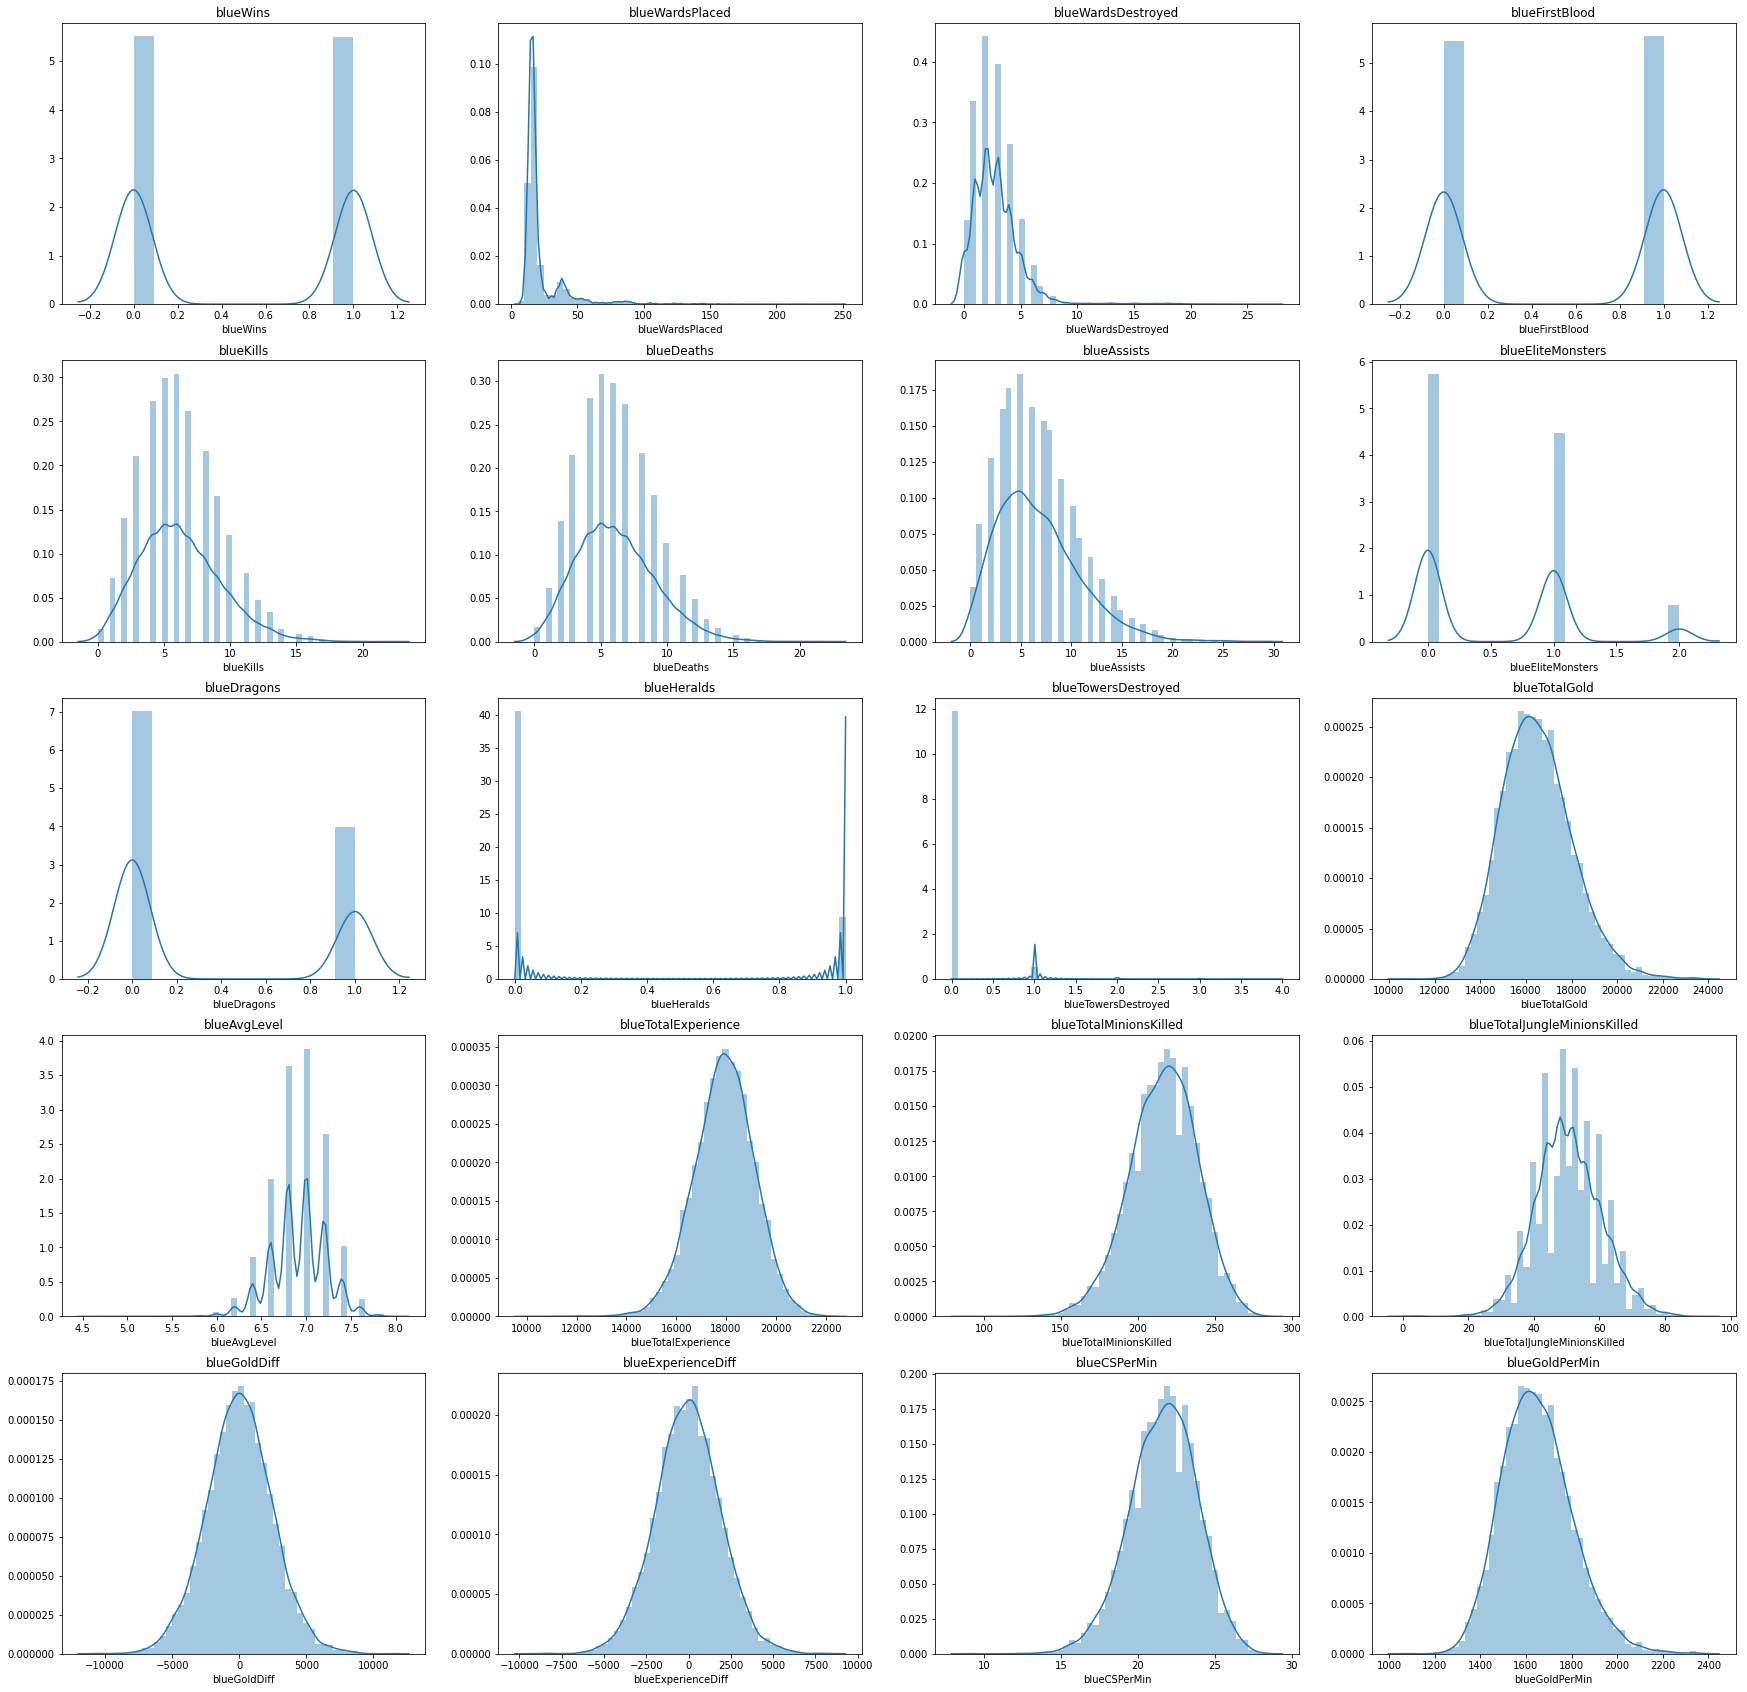

In [83]:
def plot_dist():
  fig, axes = plt.subplots(5,4, figsize = (30,30))
  for i,x in enumerate(df.columns[1:21]):
    sb.distplot(df[x], ax = axes[i//4, i%4])
    axes[i//4, i%4].set_title(x)
plot_dist()

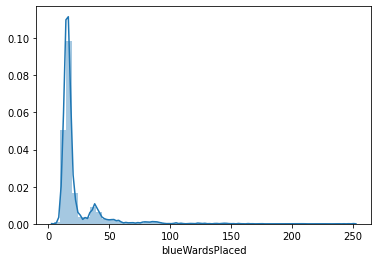

In [84]:
x = df.columns[2]
compare = df[x]
sb.distplot(df[x])

This is heavily skewed to the right! Let's apply an IQR method to filter the data

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4475365709,1,18,0,0,5,3,6,1,1,0,0,15899,7.0,18161,225,42,698,101,22.5,1589.9,36,5,1,3,5,2,0,0,0,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
4,4493010632,1,18,3,1,7,6,7,1,1,0,0,16874,6.8,16967,225,53,2411,1563,22.5,1687.4,57,1,0,6,7,9,0,0,0,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8247,4527878058,1,18,2,1,12,6,13,0,0,0,0,18573,7.2,19391,207,46,2639,2364,20.7,1857.3,16,6,0,6,12,6,0,0,0,0,15934,6.6,17027,197,38,-2639,-2364,19.7,1593.4
8248,4527873286,1,17,2,1,7,4,5,1,1,0,0,17765,7.2,18967,211,69,2519,2469,21.1,1776.5,46,3,0,4,7,7,0,0,0,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
8249,4527713716,0,23,1,0,6,7,5,0,0,0,0,15903,7.0,18032,210,45,-2416,-1877,21.0,1590.3,14,0,1,7,6,11,1,1,0,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
8250,4527628313,0,14,4,1,2,3,3,1,1,0,0,14459,6.6,17229,224,48,-839,-1085,22.4,1445.9,66,4,0,3,2,1,0,0,0,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


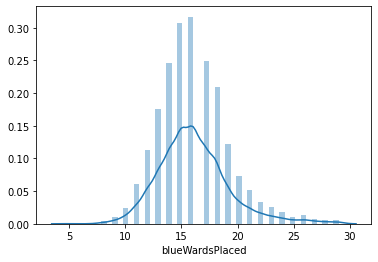

In [85]:
Q1 = df['blueWardsPlaced'].quantile(0.25)
Q3 = df['blueWardsPlaced'].quantile(0.75)
IQR = Q3 - Q1
df = df.query('(@Q1 - 1.5 * @IQR) <= blueWardsPlaced <= (@Q3 + 1.5 * @IQR)')
sb.distplot(df['blueWardsPlaced'])
df.reset_index(drop = True, inplace = True)
df

average stats for blue team if they win or not

In [86]:
df.groupby(['blueWins']).mean()

,gameId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
blueWins,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.499761e+09,15.927154,2.689981,0.402711,5.169894,7.157309,5.505566,0.402711,0.255566,0.147144,0.022991,15858.666505,6.799806,17423.266941,212.157067,49.124637,-1255.770329,-1009.295499,21.215707,1585.866651,22.943611,2.693611,0.597289,7.157309,5.169894,7.830348,0.723379,0.522265,0.201113,0.067038,17114.436834,7.034318,18432.562439,221.946757,52.392788,1255.770329,1009.295499,22.194676,1711.443683
1,4.499793e+09,16.309223,2.883010,0.608010,7.198786,5.132524,7.699757,0.685437,0.461650,0.223786,0.080825,17148.813835,7.018204,18378.863835,222.193204,51.624272,1285.907767,887.475485,22.219320,1714.881383,22.120146,2.440534,0.391990,5.132524,7.198786,5.556311,0.439563,0.314806,0.124757,0.019903,15862.906068,6.816019,17491.388350,212.569417,50.175243,-1285.907767,-887.475485,21.256942,1586.290607


In [87]:
df.groupby(['blueWins']).std()

,gameId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
blueWins,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.752817e+07,3.188011,2.167623,0.490503,2.641527,2.933531,3.588521,0.559223,0.436232,0.354293,0.151500,1312.925811,0.295467,1125.418755,21.794795,9.621886,2109.949004,1669.153067,2.179479,131.292581,18.686989,1.660053,0.490503,2.933531,2.641527,4.216946,0.651390,0.499564,0.400881,0.268778,1427.588320,0.271620,1071.561244,20.524426,10.044003,2109.949004,1669.153067,2.052443,142.758832
1,2.811016e+07,3.185152,2.147488,0.488254,3.024710,2.586857,4.157076,0.648513,0.498588,0.416831,0.306158,1480.705180,0.270144,1070.858123,20.784880,9.973434,2130.068036,1687.286645,2.078488,148.070518,18.390873,1.604303,0.488254,2.586857,3.024710,3.646525,0.576498,0.464495,0.330484,0.148119,1301.678033,0.300127,1138.166237,22.380074,9.872303,2130.068036,1687.286645,2.238007,130.167803


First of all, does blue team influence the win rate?

In [88]:
df.groupby(['blueWins']).count()

,gameId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
blueWins,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132,4132
1,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120,4120


roughly the same win rate when compared together!

# Hypothesis Testing with Boostraping

In [89]:
print('the win rate is: ', df['blueWins'].mean())

the win rate is:  0.4992729035385361


In order to conduct a hypothesis testing we need to know the standard error of our sample. 

### Boostraping

Since we only have one data point, we should use a bootstraping method to estimate the standard deviation.


In [0]:
def bootstrap(data, length = 1000, parametric = None):
  est_boostraped = np.zeros(length,)
  if parametric == None:
    for i in range(length):
      ids = np.arange(len(data))
      idx = np.random.choice(ids, len(data))
      new_data = data[idx]
      est_boostraped[i] = np.array(new_data).mean()
  elif parametric == 'normal':
    for i in range(length):
      mu = np.array(data).mean()
      sigma = np.array(data).std()
      normal = np.random.normal(mu, sigma, size = len(data))
      est_boostraped[i] = np.array(normal).mean()
  elif parametric == 'bernoulli':
    for i in range(length):
      mu = np.array(data).mean()
      boost = np.random.binomial(n = 1, p = mu, size= len(data))
      est_boostraped[i] = np.array(boost).mean()
  elif parametric == 'poisson':
    for i in range(length):
      mu = np.array(data).mean()
      boost = np.random.poisson(lam = mu, size = len(data))
      est_boostraped[i] = np.array(boost).mean()

  return est_boostraped.std()

In [91]:
n =1000


win_rate = df['blueWins'].mean()

boost_std = bootstrap(df['blueWins'], length = n)
boost_std

0.005468959080480487

In [92]:
bootstrap(df['blueWins'], length = n, parametric='normal')


0.005426702678834718

In [93]:
bootstrap(df['blueWins'], length = n, parametric='bernoulli')

0.005629572227063477

In [94]:
bootstrap(df['blueWins'], length = n, parametric='poisson')

0.008067101930546912

Let's construct a Confidence Interval

In [0]:
def construct_ci(mu, std, sig_level):
  ci = (round(mu - std * scipy.stats.norm.ppf(sig_level), 4), round(mu + std * scipy.stats.norm.ppf(sig_level),4))
  print('confidence interval: ', ci)
  return ci


In [96]:
ci = construct_ci(win_rate, boost_std, 0.90)

confidence interval:  (0.4923, 0.5063)


In [97]:
boost_std

0.005468959080480487

### Hypothesis Testing

$H_{0}$ : win_rate $=$ 0.5

$H_{a}$ : win_rate $\neq$ 0.5

Using Wald Test

In [98]:
def wald_statitics(mu, mu_bar, std):
  return (mu - mu_bar)/(std)

w = wald_statitics(win_rate, 0.5, boost_std)
print('wald statistics: ', w)

wald statistics:  -0.13294969861065858


In [0]:
def wald_p_value(stat):
  return (1 - scipy.stats.norm.cdf(np.absolute(stat)))

In [100]:
w_p_value = wald_p_value(w)
print('wald p value: ', w_p_value)

wald p value:  0.4471165809643166


Chi-square Test

In [101]:
def chisquare_statitics(mu, mu_bar, std):
  return (mu - mu_bar)**2/(std)**2
chi2 = chisquare_statitics(win_rate, 0.5, boost_std)
print('chisquare statistics is: ' , chi2)

chisquare statistics is:  0.017675622360664955


In [102]:
def chi2_p_value(stat, df):
  return (1 - scipy.stats.chi2.cdf(stat, df))
chi2_p_value = chi2_p_value(chi2, df = 1)
print('wald p value: ', chi2_p_value)

wald p value:  0.8942331619286332


In [103]:
def hypothesis_testing_win_rate():
  a = ['wald statistics', 'wald p-value', 'chisquare statistics', 'chisquare p-value', 'confidence interval']
  b = [w, w_p_value, chi2, chi2_p_value, ci]
  table = pd.DataFrame()
  table['metrics name'] = a
  table['value'] = b
  return table
hypothesis_testing_win_rate()

,metrics name,value
0,wald statistics,-0.13295
1,wald p-value,0.447117
2,chisquare statistics,0.0176756
3,chisquare p-value,0.894233
4,confidence interval,"(0.4923, 0.5063)"


By both the wald test and the chi-square independence test, we do not have enough evidence to reject $H_{0}$



if the first blood is not impacted, then are there any factors affected at all?

### hypothesis testing on all variables




First let's take a look at the tests on all the variables.

In [104]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [0]:
blue_attr = []
red_attr = []
for i in range(19):
  blue_attr.append(df.columns[i+2])
  red_attr.append(df.columns[i+21])


In [106]:
blue_attr

['blueWardsPlaced',
 'blueWardsDestroyed',
 'blueFirstBlood',
 'blueKills',
 'blueDeaths',
 'blueAssists',
 'blueEliteMonsters',
 'blueDragons',
 'blueHeralds',
 'blueTowersDestroyed',
 'blueTotalGold',
 'blueAvgLevel',
 'blueTotalExperience',
 'blueTotalMinionsKilled',
 'blueTotalJungleMinionsKilled',
 'blueGoldDiff',
 'blueExperienceDiff',
 'blueCSPerMin',
 'blueGoldPerMin']

In [107]:
red_attr

['redWardsPlaced',
 'redWardsDestroyed',
 'redFirstBlood',
 'redKills',
 'redDeaths',
 'redAssists',
 'redEliteMonsters',
 'redDragons',
 'redHeralds',
 'redTowersDestroyed',
 'redTotalGold',
 'redAvgLevel',
 'redTotalExperience',
 'redTotalMinionsKilled',
 'redTotalJungleMinionsKilled',
 'redGoldDiff',
 'redExperienceDiff',
 'redCSPerMin',
 'redGoldPerMin']

In [0]:
from tqdm import tqdm
class statistical_check:
  def __init__(self, df):

    self.attr = df.columns.values.tolist()
    red_attr = []
    blue_attr = []
    try:
      single_length = int(len(self.attr)/2 - 1)
    except:
      raise ValueError('attributes number not equal on both sides, check on df again')
    for i in range(single_length):
      blue_attr.append(self.attr[i+2])
      red_attr.append(self.attr[single_length + i+2])
    self.blue_attr = blue_attr
    self.red_attr = red_attr
    df2 = df[['gameId', 'blueWins']]
    analyze_attr = []
    for i in range(len(blue_attr)):
      df2[blue_attr[i] + ' - ' + red_attr[i]] = df[blue_attr[i]] - df[red_attr[i]]
      analyze_attr.append(blue_attr[i] + ' - ' + red_attr[i])
    self.analyze_attr = analyze_attr
    self.data = df2
    
    self.report = None
    
  def bootstrapping(self, data, length = 1000, parametric = None):
    est_boostraped = np.zeros(length,)
    if parametric == None:
      for i in range(length):
        ids = np.arange(len(data))
        idx = np.random.choice(ids, len(data))
        new_data = data[idx]
        est_boostraped[i] = np.array(new_data).mean()
    elif parametric == 'normal':
      for i in range(length):
        mu = np.array(data).mean()
        sigma = np.array(data).std()
        normal = np.random.normal(mu, sigma, size = len(data))
        est_boostraped[i] = np.array(normal).mean()
    elif parametric == 'bernoulli':
      for i in range(length):
        mu = np.array(data).mean()
        boost = np.random.binomial(n = 1, p = mu, size= len(data))
        est_boostraped[i] = np.array(boost).mean()
    elif parametric == 'poisson':
      for i in range(length):
        mu = np.array(data).mean()
        boost = np.random.poisson(lam = mu, size = len(data))
        est_boostraped[i] = np.array(boost).mean()

    return est_boostraped.std()

  
  def construct_ci(self, mu, std, sig_level):
    print('confidence interval: ', (mu - std * scipy.stats.norm.ppf(sig_level), mu + std * scipy.stats.norm.ppf(sig_level)))

  def wald_statitics(self, mu, mu_bar, std):
    return round((mu - mu_bar)/(std), 3)

  def wald_p_value(self, stat):
    return round((1 - scipy.stats.norm.cdf(np.absolute(stat))),3)

  def chisquare_statitics(self, mu, mu_bar, std):
    return round((mu - mu_bar)**2/(std)**2, 3)

  def chisquare_p_value(self, stat, df = 1):
    return round((1 - scipy.stats.chi2.cdf(stat, df)),3)
  
  def analyze(self, attr_list = None):
    if attr_list == None:
      attr_list = self.analyze_attr

    data = self.data
    mus = []
    boost_stds = []
    ws = []
    w_p_values = []
    chi2s = []
    chi2_p_values = []
    for attr in tqdm(attr_list):
      mu = data[attr].mean()
      mus.append(mu)
      boost_std = self.bootstrapping(data[attr])
      boost_stds.append(boost_std)

      w = self.wald_statitics(mu, 0, boost_std)
      ws.append(w)
      w_p_value = self.wald_p_value(w)
      w_p_values.append(w_p_value)

      chi2 = self.chisquare_statitics(mu, 0, boost_std)
      chi2s.append(chi2)
      chi2_p = self.chisquare_p_value(chi2)
      chi2_p_values.append(chi2_p)
    report = pd.DataFrame({'attr':attr_list, 'mean':mus, 'boostrapped std': boost_stds, 'wald stats': ws, 
                         'wald p-value': w_p_values, 'chi2 stats': chi2s, 
                         'chi2 p-value': chi2_p_values})
    self.report = report
    return report




In [109]:
report = statistical_check(df).analyze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


In [110]:
report.sort_values(by = 'chi2 p-value')

,attr,mean,boostrapped std,wald stats,wald p-value,chi2 stats,chi2 p-value
0,blueWardsPlaced - redWardsPlaced,-6.414566,0.203306,-31.551,0.000,995.480,0.000
1,blueWardsDestroyed - redWardsDestroyed,0.219098,0.027444,7.983,0.000,63.735,0.000
14,blueTotalJungleMinionsKilled - redTotalJungleM...,-0.912991,0.158531,-5.759,0.000,33.167,0.000
7,blueDragons - redDragons,-0.060228,0.009636,-6.250,0.000,39.063,0.000
6,blueEliteMonsters - redEliteMonsters,-0.037809,0.011523,-3.281,0.001,10.767,0.001
8,blueHeralds - redHeralds,0.022419,0.006582,3.406,0.000,11.600,0.001
16,blueExperienceDiff - redExperienceDiff,-124.578284,40.220189,-3.097,0.001,9.594,0.002
11,blueAvgLevel - redAvgLevel,-0.016481,0.005475,-3.010,0.001,9.060,0.003
12,blueTotalExperience - redTotalExperience,-62.289142,21.356052,-2.917,0.002,8.507,0.004
9,blueTowersDestroyed - redTowersDestroyed,0.008362,0.003358,2.490,0.006,6.201,0.013


# Win Conditions Analysis

What are the most important factors that contributes to the winning of the blue team? 

Let's analyze this by using a logistics regression!

### Logistics Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
clf = LogisticRegression()
train_labels_1 = df.columns[2:11]
train_labels_1 = train_labels_1.drop(['blueEliteMonsters', 'blueAssists'])
# train_labels_1 = train_labels_1.append(pd.Index(['blueCSPerMin']))
X1 = df[train_labels_1]
X1.drop
X1_n = pd.DataFrame(normalize(X1))
X1_n.columns = train_labels_1
mms = MinMaxScaler()
X1_mms = pd.DataFrame( mms.fit_transform(X1))
X1_mms.columns = train_labels_1
ss = StandardScaler()
X1_ss = pd.DataFrame(ss.fit_transform(X1))
X1_ss.columns = train_labels_1


y = df['blueWins']



In [112]:
X1_mms.corr()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueDragons,blueHeralds
blueWardsPlaced,1.000000,0.102828,0.038911,0.070850,-0.081518,0.027489,0.013637
blueWardsDestroyed,0.102828,1.000000,0.011638,0.032563,-0.075055,0.038846,0.017310
blueFirstBlood,0.038911,0.011638,1.000000,0.272035,-0.242154,0.134741,0.072363
blueKills,0.070850,0.032563,0.272035,1.000000,0.000315,0.177625,0.076872
blueDeaths,-0.081518,-0.075055,-0.242154,0.000315,1.000000,-0.186630,-0.090207
blueDragons,0.027489,0.038846,0.134741,0.177625,-0.186630,1.000000,0.014668
blueHeralds,0.013637,0.017310,0.072363,0.076872,-0.090207,0.014668,1.000000


In [113]:
import statsmodels.api as sm
logit =  sm.Logit(y, X1)
result = logit.fit_regularized()
result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5541474000702283
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               blueWins   No. Observations:                 8252
Model:                          Logit   Df Residuals:                     8245
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 May 2020   Pseudo R-squ.:                  0.2005
Time:                        15:44:26   Log-Likelihood:                -4572.8
converged:                       True   LL-Null:                       -5719.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
blueWardsPlaced       -0.0077      0.005     -1.650      0.099      -0.017       0.001
blueWardsDestroyed    -0.0002      0.012     -0.017      0.986      -0.023       0.023
blueFirstBlood         0.1014      0.052      1.935      0.053      -0.001       0.204
blueKills              0.2712      0.010     27.242      0.000       0.252       0.291
blueDeaths            -0.2965      0.010    -31.074      0.000      -0.315      -0.278
blueDragons            0.4882      0.053      9.138      0.000       0.384       0.593
blueHeralds            0.2733      0.065      4.175      0.000       0.145       0.402
======================================================================================
"""

In [114]:
logit_mms = sm.Logit(y, X1_mms)
result_mms = logit_mms.fit_regularized()
result_mms.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5542261853093559
            Iterations: 50
            Function evaluations: 50
            Gradient evaluations: 50


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               blueWins   No. Observations:                 8252
Model:                          Logit   Df Residuals:                     8245
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 May 2020   Pseudo R-squ.:                  0.2004
Time:                        15:44:26   Log-Likelihood:                -4573.5
converged:                       True   LL-Null:                       -5719.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
blueWardsPlaced       -0.1669      0.140     -1.194      0.233      -0.441       0.107
blueWardsDestroyed    -0.0719      0.313     -0.230      0.818      -0.685       0.541
blueFirstBlood         0.0940      0.052      1.805      0.071      -0.008       0.196
blueKills              5.9247      0.216     27.372      0.000       5.500       6.349
blueDeaths            -6.5931      0.202    -32.684      0.000      -6.988      -6.198
blueDragons            0.4829      0.053      9.068      0.000       0.378       0.587
blueHeralds            0.2688      0.065      4.114      0.000       0.141       0.397
======================================================================================
"""

In [115]:
logit_ss = sm.Logit(y, X1)
result_ss = logit_ss.fit_regularized()
result_ss.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5541474000702283
            Iterations: 26
            Function evaluations: 28
            Gradient evaluations: 26


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               blueWins   No. Observations:                 8252
Model:                          Logit   Df Residuals:                     8245
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 May 2020   Pseudo R-squ.:                  0.2005
Time:                        15:44:26   Log-Likelihood:                -4572.8
converged:                       True   LL-Null:                       -5719.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
blueWardsPlaced       -0.0077      0.005     -1.650      0.099      -0.017       0.001
blueWardsDestroyed    -0.0002      0.012     -0.017      0.986      -0.023       0.023
blueFirstBlood         0.1014      0.052      1.935      0.053      -0.001       0.204
blueKills              0.2712      0.010     27.242      0.000       0.252       0.291
blueDeaths            -0.2965      0.010    -31.074      0.000      -0.315      -0.278
blueDragons            0.4882      0.053      9.138      0.000       0.384       0.593
blueHeralds            0.2733      0.065      4.175      0.000       0.145       0.402
======================================================================================
"""

### Linear Regression

what factors contributes to the total gold the most?

In [116]:
df.columns[2:21]

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
       'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'],
      dtype='object')

In [117]:
y2 = df['blueTotalGold']
# X_labels = df.columns[2:11]
# X2 = df[X_labels]
X2 = X1
ols = sm.OLS(y2, X2)
result_ols = ols.fit()
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          blueTotalGold   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          5.679e+04
Date:                Sun, 17 May 2020   Prob (F-statistic):                        0.00
Time:                        15:44:26   Log-Likelihood:                         -75807.
No. Observations:                8252   AIC:                                  1.516e+05
Df Residuals:                    8245   BIC:                                  1.517e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
blueWardsPlaced      582.3570      4.862    119.785      0.000     572.827     591.887
blueWardsDestroyed   166.2778     12.020     13.833      0.000     142.715     189.841
blueFirstBlood       888.2048     55.254     16.075      0.000     779.893     996.516
blueKills            591.9691      9.002     65.758      0.000     574.323     609.616
blueDeaths           296.9716      8.299     35.785      0.000     280.704     313.239
blueDragons          601.5472     55.827     10.775      0.000     492.112     710.982
blueHeralds          734.2605     67.273     10.915      0.000     602.388     866.133
==============================================================================
Omnibus:                      374.716   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              461.802
Skew:                          -0.486   Prob(JB):                    5.26e-101
Kurtosis:                       3.632   Cond. No.                         48.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

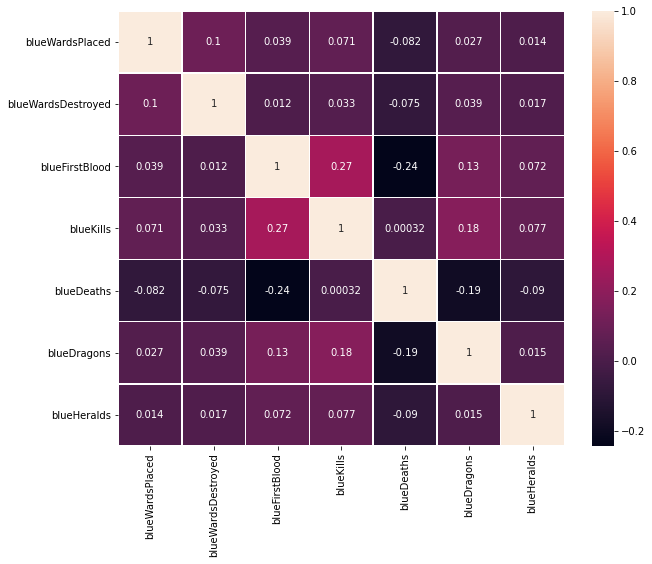

In [118]:
plt.figure(figsize = (10,8))
sb.heatmap(X1_mms.corr(), linewidths=0.5, annot = True)
plt.show()

# Something New: Decision Tree and Random Forest

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
X_train, X_test, y_train, y_test = train_test_split(X1_mms, y, test_size=0.2, random_state=42)
dtc = DecisionTreeClassifier(criterion = 'entropy')
dtc.fit(X_train, y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [120]:
print('in-sample-accuracy: ', dtc.score(X_train, y_train))
print('in-sample-f1: ', f1_score(dtc.predict(X_train), y_train))
print('out-of-sample-accuracy: ', dtc.score(X_test, y_test))
print('out-of-sample-f1: ', f1_score(dtc.predict(X_test), y_test))


in-sample-accuracy:  0.9613694894712922
in-sample-f1:  0.9598993552445353
out-of-sample-accuracy:  0.6244700181708056
out-of-sample-f1:  0.6115288220551379


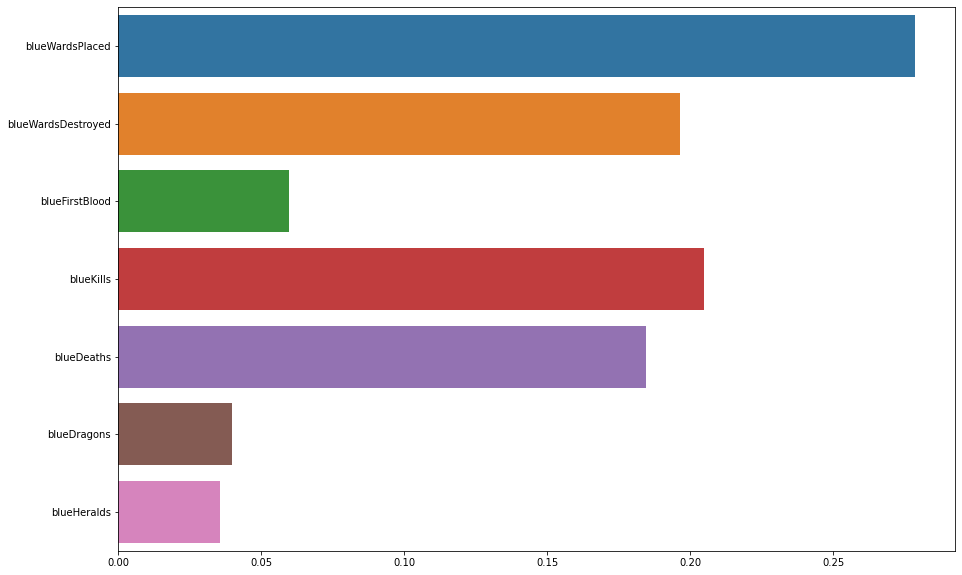

In [121]:
plt.figure(figsize=(15,10))
sb.barplot(dtc.feature_importances_, train_labels_1)
plt.show()

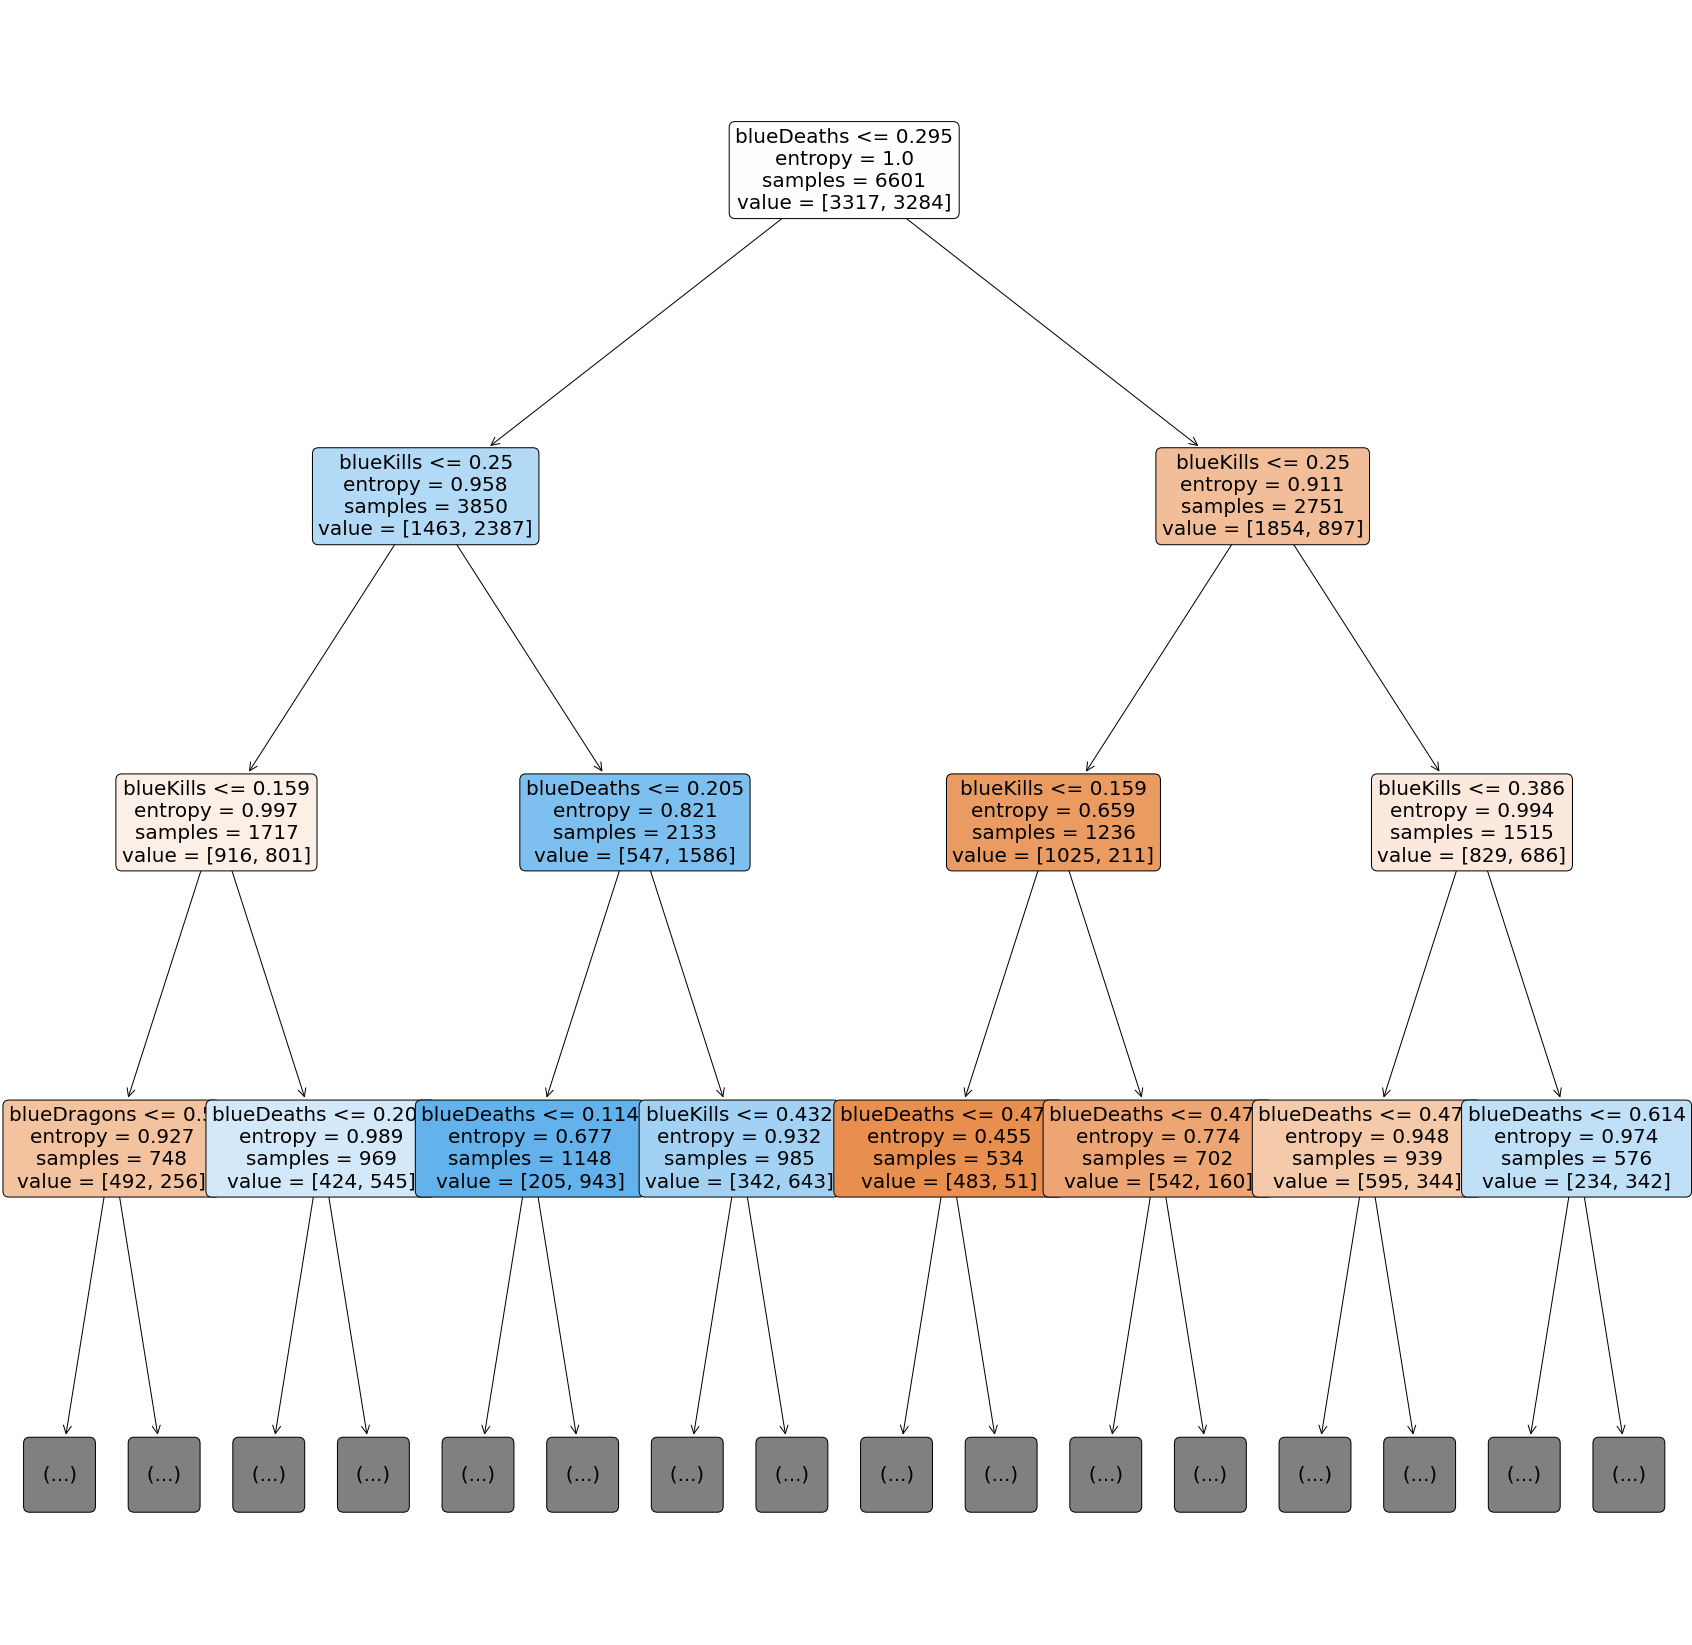

In [122]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,30))
plot_tree(dtc, filled = True, max_depth=3, rounded=True, 
              fontsize=20, feature_names=train_labels_1)

plt.show()

### Random Forest

In [123]:
from  sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion = 'entropy')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [124]:
print('in-sample-accuracy: ', rfc.score(X_train, y_train))
print('in-sample-f1: ', f1_score(rfc.predict(X_train), y_train))
print('out-of-sample-accuracy: ', rfc.score(X_test, y_test))
print('out-of-sample-f1: ', f1_score(rfc.predict(X_test), y_test))

in-sample-accuracy:  0.9613694894712922
in-sample-f1:  0.9609434829223463
out-of-sample-accuracy:  0.6723198061780739
out-of-sample-f1:  0.6770149253731343


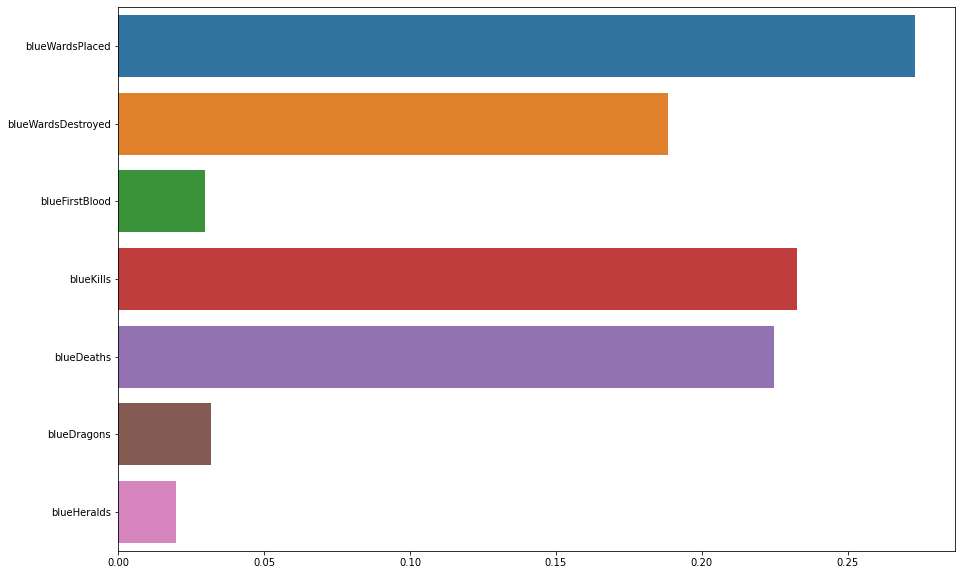

In [125]:
plt.figure(figsize=(15,10))
sb.barplot(rfc.feature_importances_, train_labels_1)
plt.show()

In [127]:
lr = LogisticRegression(random_state= 42)
lr.fit(X_train, y_train)
print('in-sample-accuracy: ', lr.score(X_train, y_train))
print('in-sample-f1: ', f1_score(lr.predict(X_train), y_train))
print('out-of-sample-accuracy: ', lr.score(X_test, y_test))
print('out-of-sample-f1: ', f1_score(lr.predict(X_test), y_test))

in-sample-accuracy:  0.7083775185577943
in-sample-f1:  0.7071352502662408
out-of-sample-accuracy:  0.7098728043609933
out-of-sample-f1:  0.7105740181268881


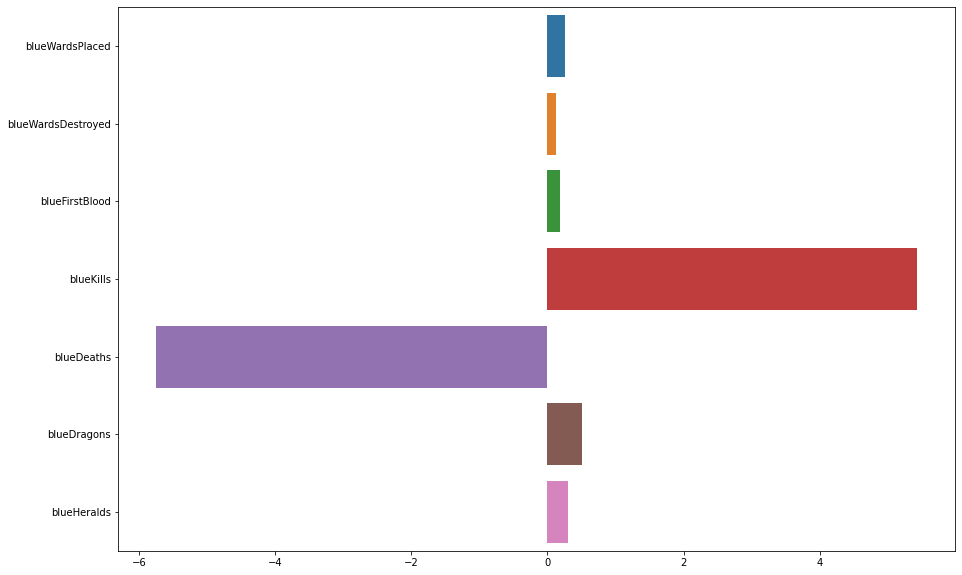

In [128]:
plt.figure(figsize=(15,10))
sb.barplot(lr.coef_[0], train_labels_1)
plt.show()

In [129]:
def classifier_report():
  train_f1 = []
  train_acc = []
  test_f1 = []
  test_acc = []
  classifier = ['decision tree', 'random forest', 'logistic regression']
  for x in [dtc, rfc, lr]:
    train_f1.append(f1_score(x.predict(X_train), y_train))
    train_acc.append(x.score(X_train, y_train))
    test_f1.append(f1_score(x.predict(X_test), y_test))
    test_acc.append(x.score(X_test, y_test))
  report = pd.DataFrame({'classifier':classifier, 'train f1':train_f1, 'train acc':train_acc,
                        'test f1':test_f1, 'test acc':test_acc})
  return report
classifier_report()

,classifier,train f1,train acc,test f1,test acc
0,decision tree,0.959899,0.961369,0.611529,0.624470
1,random forest,0.960943,0.961369,0.677015,0.672320
2,logistic regression,0.707135,0.708378,0.710574,0.709873
